In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt


os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/DataSets/'
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + 'Training/',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(32, 32),
    shuffle=True,
    seed=123
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + 'Testing/',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(32, 32),
    shuffle=False
)

Found 2600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


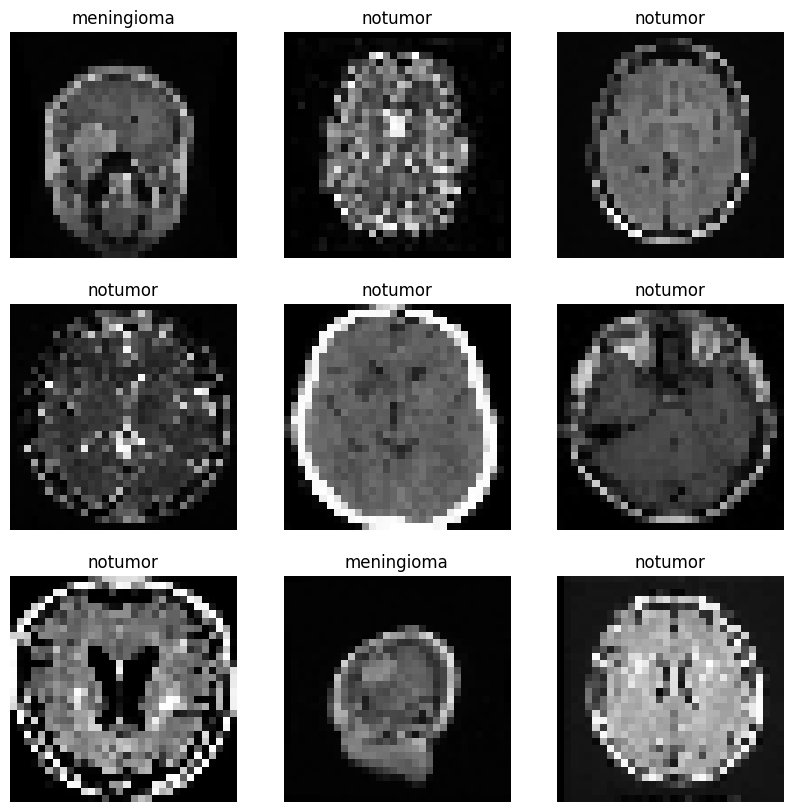

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(name=name + '_0_bn')(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name + '_1_conv')(x)
    x = layers.BatchNormalization(name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = layers.BatchNormalization(name=name + '_2_bn')(x)

    x = layers.add([shortcut, x], name=name + '_add')
    x = layers.Activation('relu', name=name + '_out')(x)
    return x

def resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', name='conv1_conv')(inputs)
    x = layers.BatchNormalization(name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same', name='pool1_pool')(x)

    x = resnet_block(x, 64, conv_shortcut=False, name='conv2_block1')
    x = resnet_block(x, 64, name='conv2_block2')
    x = layers.Dropout(0.3)(x)

    x = resnet_block(x, 128, stride=2, name='conv3_block1')
    x = resnet_block(x, 128, name='conv3_block2')
    x = layers.Dropout(0.3)(x)

    x = resnet_block(x, 256, stride=2, name='conv4_block1')
    x = resnet_block(x, 256, name='conv4_block2')
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs, outputs, name='resnet')
    return model


input_shape = (32, 32, 3)
num_classes = 2

model = resnet(input_shape, num_classes)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1_relu (Activation)     (None, 16, 16, 64)           0         ['conv1_bn[0][0]']       

In [7]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

import matplotlib.pyplot as plt

Epoch 1/10
82/82 [==============================] - 349s 4s/step - loss: 0.5309 - accuracy: 0.7673 - val_loss: 0.6110 - val_accuracy: 0.6433
Epoch 2/10
82/82 [==============================] - 10s 119ms/step - loss: 0.2850 - accuracy: 0.8858 - val_loss: 0.4086 - val_accuracy: 0.8400
Epoch 3/10
82/82 [==============================] - 10s 119ms/step - loss: 0.2197 - accuracy: 0.9150 - val_loss: 0.2777 - val_accuracy: 0.8817
Epoch 4/10
82/82 [==============================] - 10s 113ms/step - loss: 0.1860 - accuracy: 0.9273 - val_loss: 0.2055 - val_accuracy: 0.9133
Epoch 5/10
82/82 [==============================] - 10s 111ms/step - loss: 0.1549 - accuracy: 0.9396 - val_loss: 0.2336 - val_accuracy: 0.9033
Epoch 6/10
82/82 [==============================] - 11s 124ms/step - loss: 0.1117 - accuracy: 0.9615 - val_loss: 0.0921 - val_accuracy: 0.9683
Epoch 7/10
82/82 [==============================] - 11s 123ms/step - loss: 0.0862 - accuracy: 0.9673 - val_loss: 0.0997 - val_accuracy: 0.9700
E

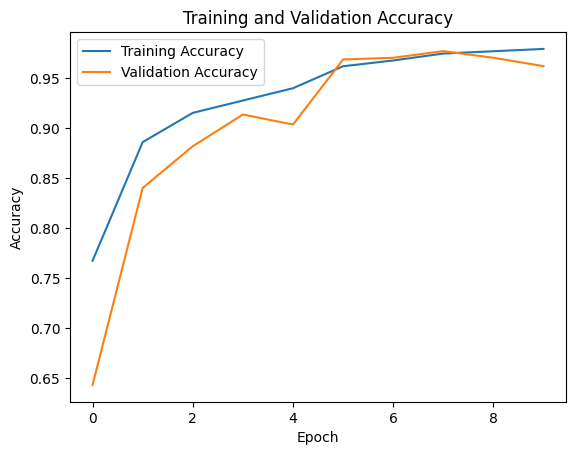

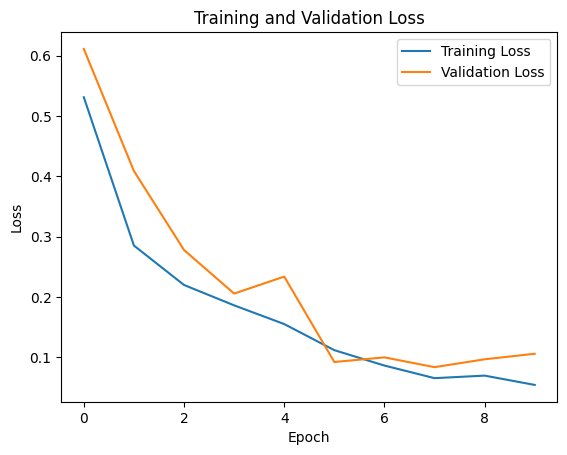

In [8]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()